<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Data exploration</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Data exploration, analysis

In [1]:
import _mypath
import os
import pandas as pd
import re
import numpy as np
from random import choice

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
nltk.data.path.append("/data/DATALAB_PAU/18_HPC/nltk_data")

from nltk.corpus import stopwords

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from data.processing import findCAPSLOCK, find_chain_CAPSLOCK, find_exclamation, find_chain_exclamation, find_interogation
from data.processing import find_chain_interogation, find_etc, check_tokens, plot_word_cloud, preprocess_comments
from data.processing import return_ngram, plotNgramsPerStars

%load_ext autoreload
%autoreload 1

In [2]:
stop_words = stopwords.words('french')

# Data loading

In [4]:
infile = os.path.join("../input/processed/cleaned_merged_dataset.csv")
df = pd.read_csv(infile, sep=",", encoding="utf-8", engine="python")
print("data shape:", df.shape, end="\n\n")

df.head()

data shape: (105568, 8)



,Commentaire,star,date,client,reponse,source,company,langage
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr


# Analysis

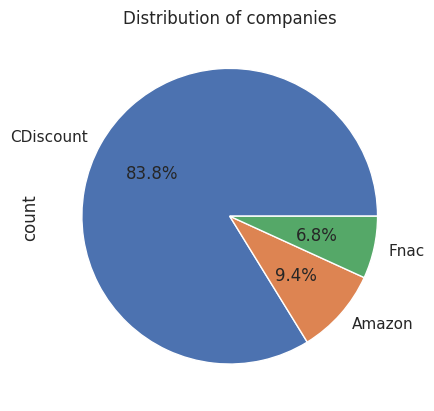

In [3]:
sns.set()
df["company"].value_counts().plot.pie(autopct="%.1f%%")
plt.title("Distribution of companies")
plt.show()

In [4]:
df.star.value_counts().sort_index(ascending=False)

star
5    53033
4    18427
3     6360
2     3607
1    24141
Name: count, dtype: int64

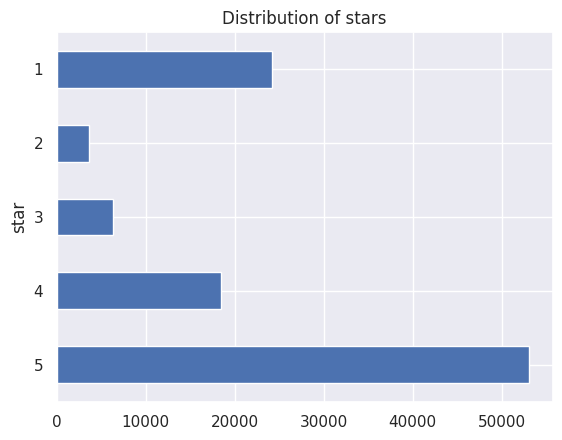

In [5]:
df.star.value_counts().sort_index(ascending=False).plot.barh()
plt.title("Distribution of stars")
plt.show()

In [6]:
df.source.value_counts()

source
TrustPilot    105568
Name: count, dtype: int64

## Reviews

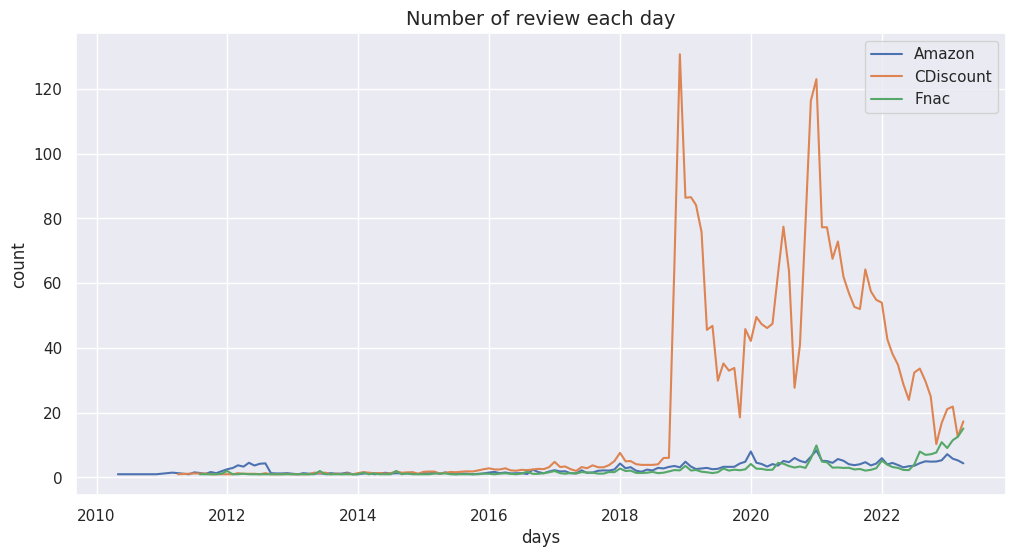

In [7]:
df.date = pd.to_datetime(df.date, utc=True)
values = pd.pivot_table(df[["date", "company"]], index="date", columns="company", aggfunc=len)
values = values.resample('M').mean()
values = pd.DataFrame(values.stack())
values.columns = ["count"]
values.reset_index(drop=False)

plt.figure(figsize=(12,6))
plt.title('Number of review each day', fontsize=14)
sns.lineplot(data=values, x='date', y='count', hue='company')
plt.xlabel("days")
plt.legend()
plt.show()

In [3]:
stats_words = check_tokens(df, n_jobs=8)

105568it [01:06, 1579.85it/s]


Text(0.5, 0, 'nb words per comment')

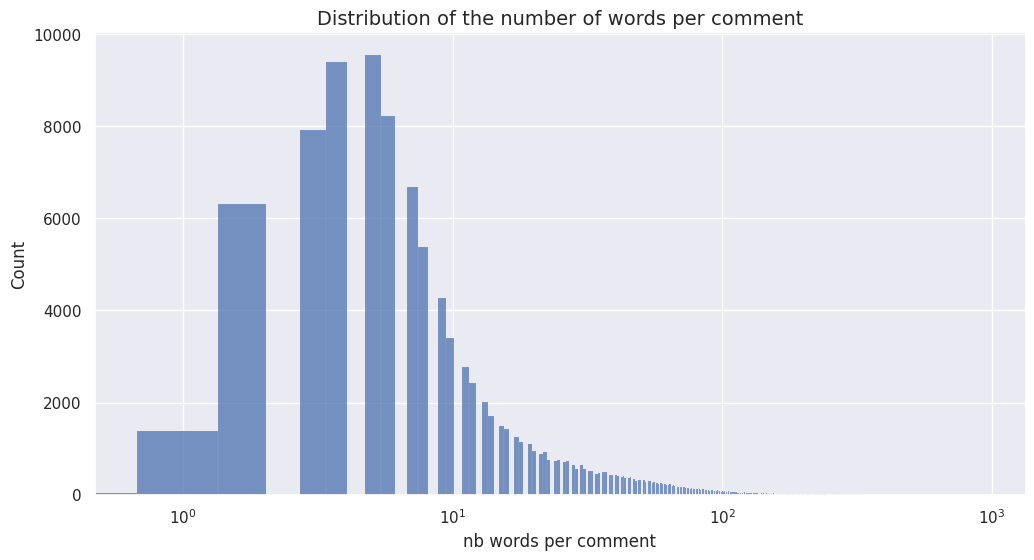

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.title('Distribution of the number of words per comment', fontsize=14)

sns.despine(fig)

sns.histplot(df, x="nb_words")
ax.set_xscale('log')
plt.xlabel("nb words per comment")

In [12]:
stats = pd.DataFrame(df["nb_words"].describe(), columns=["nb_words"])
stats.loc["95%"] = [df["nb_words"].quantile(0.95)]
stats["nb_words"] = stats["nb_words"].map("{0:.1f}".format)
stats = stats.reindex(index = ["count", "mean", "std", "min", "25%", "50%", "75%", "95%", "max"])
stats

,nb_words
count,105568.0
mean,20.3
std,33.7
min,0.0
25%,5.0
50%,8.0
75%,21.0
95%,79.0
max,922.0


In [4]:
mask = (df["nb_words"]>800)
index = choice(df[mask].index.tolist())
print("index:", index)

text = df.at[index, "Commentaire"]
wrap = 20
tokens = text.split(" ")
start = 0
for i in range(wrap,len(tokens),wrap):
    print(" ".join(tokens[start:i]))
    start = i
if i<len(tokens)-1:
    print(" ".join(tokens[i:]))

index: 97717
Cdiscount : Incompétence? Voici mon histoire et mes déboires avec Cdiscount (commande n°1504232156S55JI) Le 23/04, je commande d’un salon de
jardin Moorea – Paiement effectué par carte le jour même via l’application bancontact Le 23/04 : Mail de Cdiscount :
Suivi de votre commande : Confirmation de commande Le 24/04 : Mail de Cdiscount : Suivi de votre commande :
Validation de commande 	«  Le paiement de votre commande est validé Nous vous tiendrons informé par mail de la
fin de sa préparation …. Livraison prévue entre le 12/05 et le 19/05/2015 » Le 27/04 : mail me demandant
de confirmer le RDV avec C Chez Vous (la société de livraison) 	Impossible de consulter la date sur leur site
Le 28/04 : mail de rendez-vous automatique Livraison prévue le 12/05 entre 08 :00 et 13 :00 Le 11/05 :
Ne voyant pas de date de rendez-vous sur mon espace CChezVous, je décide de les contacter par téléphone sans succès
Le 11/05 : Appel au Service clients Cdiscount qui me confirme que la livra

Text(0.5, 0, 'word length')

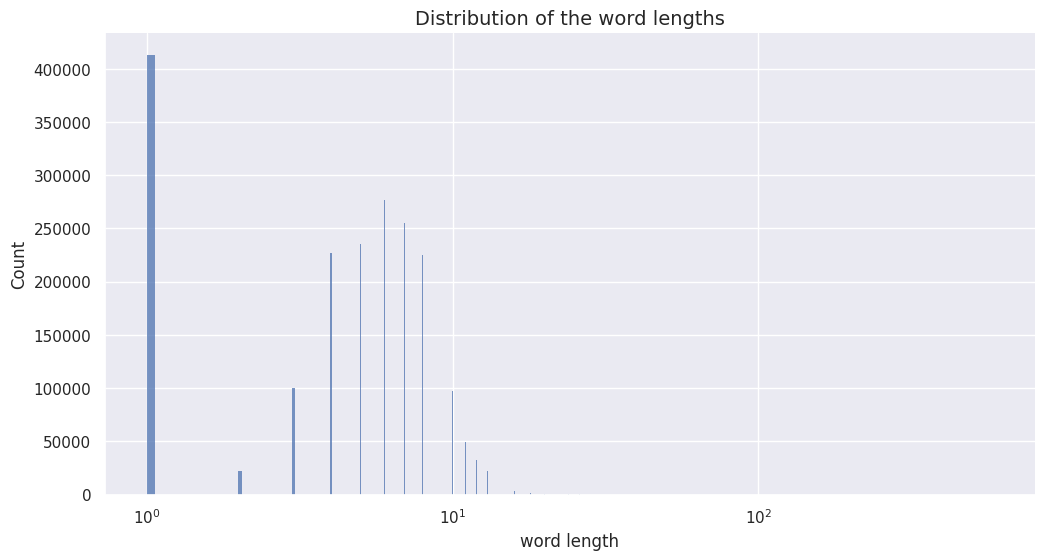

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.title('Distribution of the word lengths', fontsize=14)

sns.despine(fig)

sns.histplot(stats_words)
ax.set_xscale('log')
plt.xlabel("word length")

In [16]:
stats = pd.DataFrame(stats_words, columns=["word_length"]).describe()
stats.loc["95%"] = [np.quantile(stats_words, 0.95)]
stats.loc["99%"] = [np.quantile(stats_words, 0.99)]
stats["word_length"] = stats["word_length"].map("{0:.1f}".format)
stats = stats.reindex(index = ["count", "mean", "std", "min", "25%", "50%", "75%", "95%", "99%", "max"])
stats

,word_length
count,2146396.0
mean,5.7
std,3.3
min,1.0
25%,4.0
50%,6.0
75%,8.0
95%,11.0
99%,14.0
max,584.0


In [13]:
mask = (df["words_max_len"]>400)
index = choice(df[mask].index.tolist())
print("index:", index)

text = df.at[index, "Commentaire"]
wrap = 200
start = 0
for i in range(wrap,len(text),wrap):
    print(text[start:i])
    start = i
if start<len(text)-1:
    print(text[start:])

index: 64961
déjà fait...............................................................................................................................................................................................
........................................................................................................................................................................................................
.................................................................................................................................................................................................


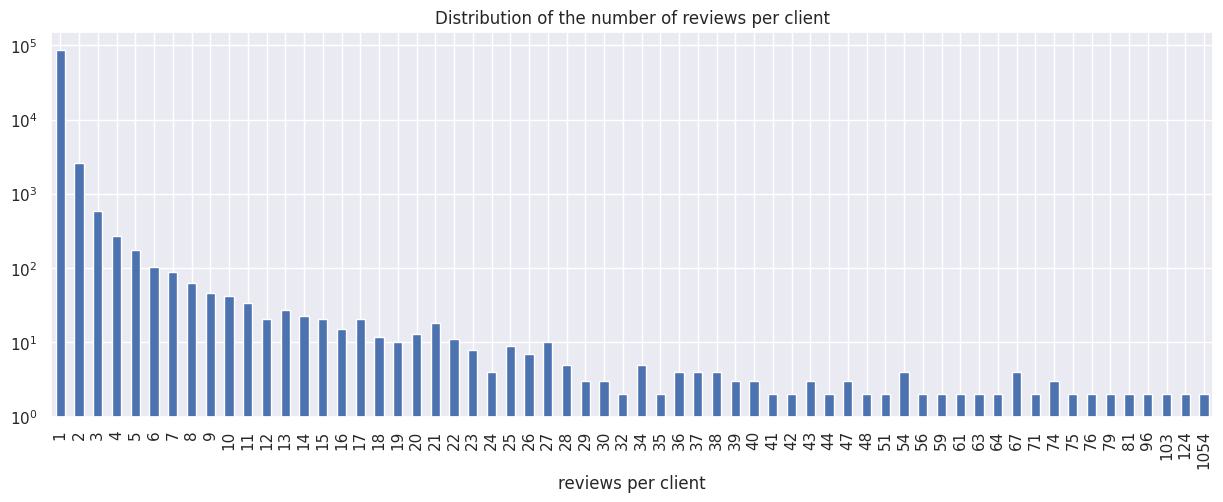

In [6]:
grouped_df = df.groupby('client').agg({'star': ['mean', 'count']})
grouped_df.columns = ['mean_star', 'star_count']

values = grouped_df["star_count"].value_counts().sort_index(ascending=True)

sns.set()
fig = plt.figure(figsize=(15,5))
values.plot.bar(log=True)
plt.xlabel("reviews per client")
plt.title("Distribution of the number of reviews per client")
plt.show()

Bins: [0:2.0[ , code: 0
Bins: [2.0:4.0[ , code: 1
Bins: [4.0:1055[ , code: 2


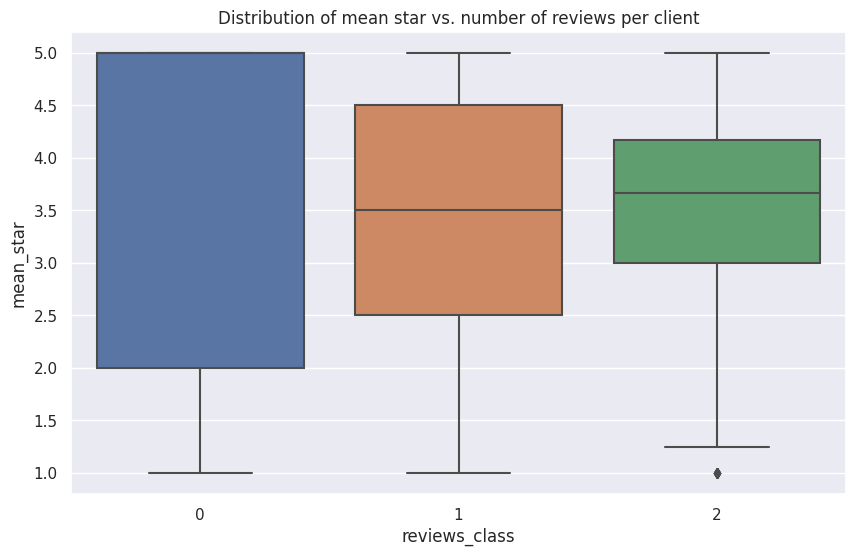

In [17]:
bins = [0]
for q in [.953,0.99]:
    bins += [np.quantile(grouped_df["star_count"].values, q)]
bins += [grouped_df["star_count"].max()+1]

code = 0
grouped_df["reviews_class"] = 0
for i,j in zip(bins[:-1], bins[1:]):
    mask = (grouped_df["star_count"]>=i) & (grouped_df["star_count"]<j)
    grouped_df.loc[mask, "reviews_class"] = code

    print("Bins: ["+str(i)+":"+str(j)+"[ , code: "+str(code))
    code += 1

fig, ax = plt.subplots(figsize=[10,6])
sns.boxplot(x="reviews_class", y="mean_star", data=grouped_df, ax=ax)
plt.title("Distribution of mean star vs. number of reviews per client")
plt.show()

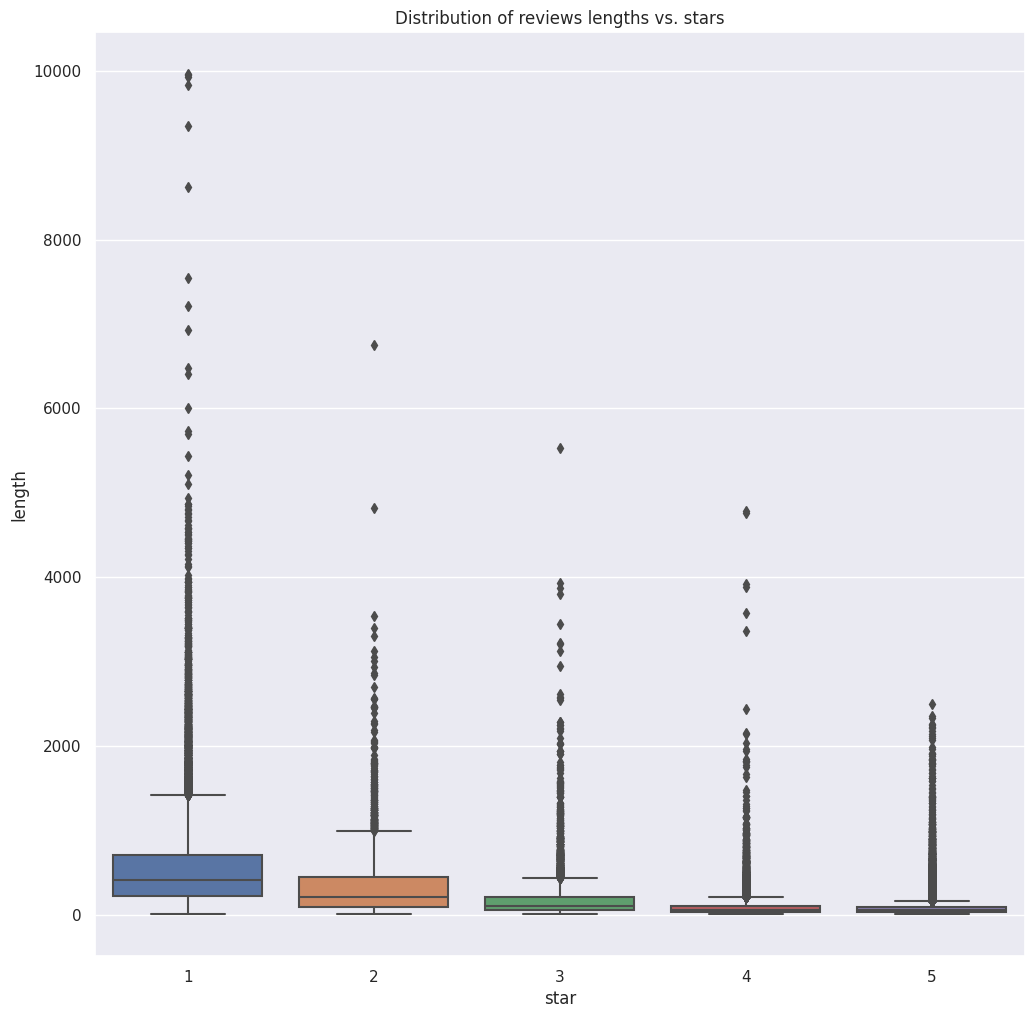

In [20]:
df['length'] = df['Commentaire'].str.len()

fig, ax = plt.subplots(figsize=[12,12])
ax.set_title("Distribution of reviews lengths vs. stars")
sns.boxplot(x="star", y="length", data=df, ax=ax)
plt.show()

In [5]:
df['capslock'] = df.Commentaire.apply(lambda x: findCAPSLOCK(str(x)))
df['chain_capslock'] = df.Commentaire.apply(lambda x: find_chain_CAPSLOCK(str(x)))
df['exclamation'] = df.Commentaire.apply(lambda x: find_exclamation(str(x)))
df['chain_exclamation'] = df.Commentaire.apply(lambda x: find_chain_exclamation(str(x)))
df['interogation'] = df.Commentaire.apply(lambda x: find_interogation(str(x)))
df['chain_interogation'] = df.Commentaire.apply(lambda x: find_chain_interogation(str(x)))

df['etc'] = df.Commentaire.apply(lambda x: find_etc(str(x)))

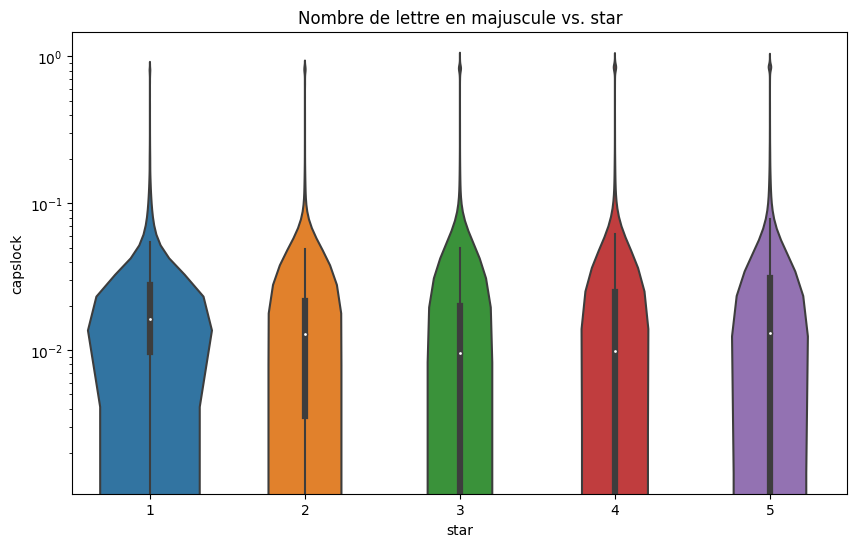

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="star", y="capslock", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de lettre en majuscule vs. star")
plt.show()

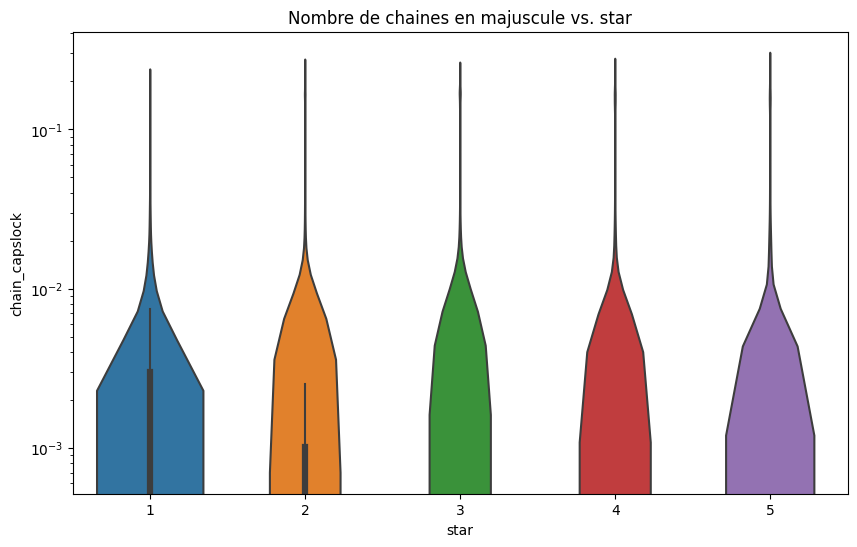

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="star", y="chain_capslock", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de chaines en majuscule vs. star")
plt.show()

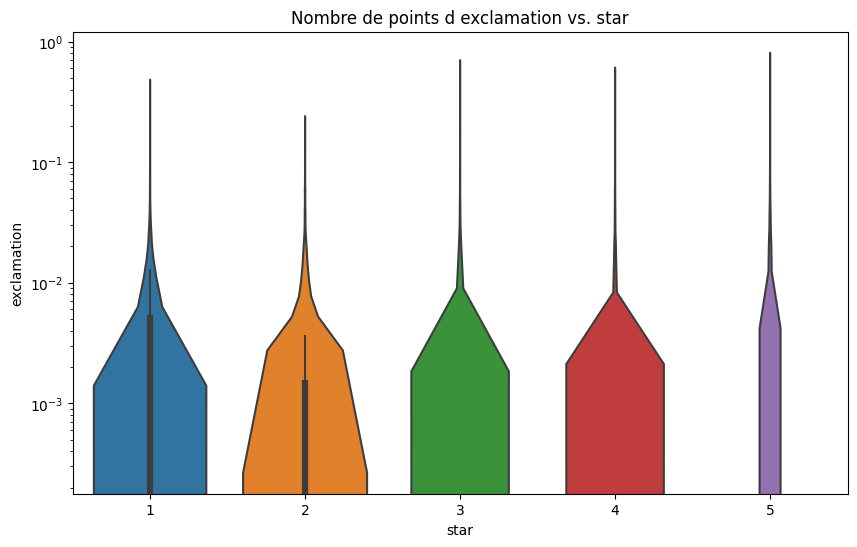

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="star", y="exclamation", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de points d exclamation vs. star")
plt.show()

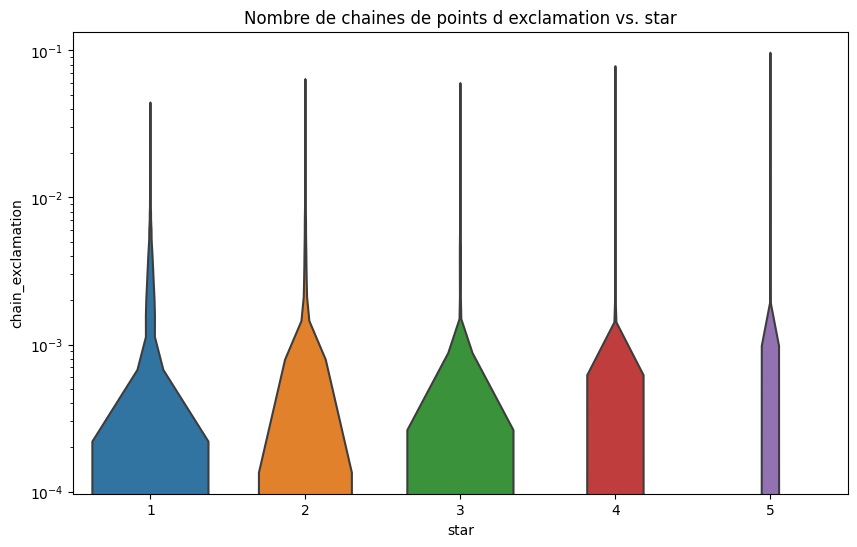

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="star", y="chain_exclamation", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de chaines de points d exclamation vs. star")
plt.show()

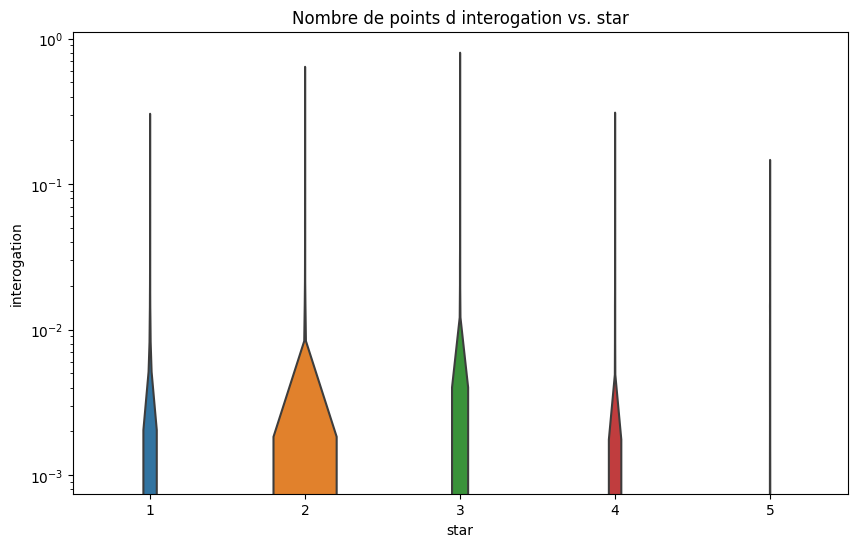

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="star", y="interogation", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de points d interogation vs. star")
plt.show()

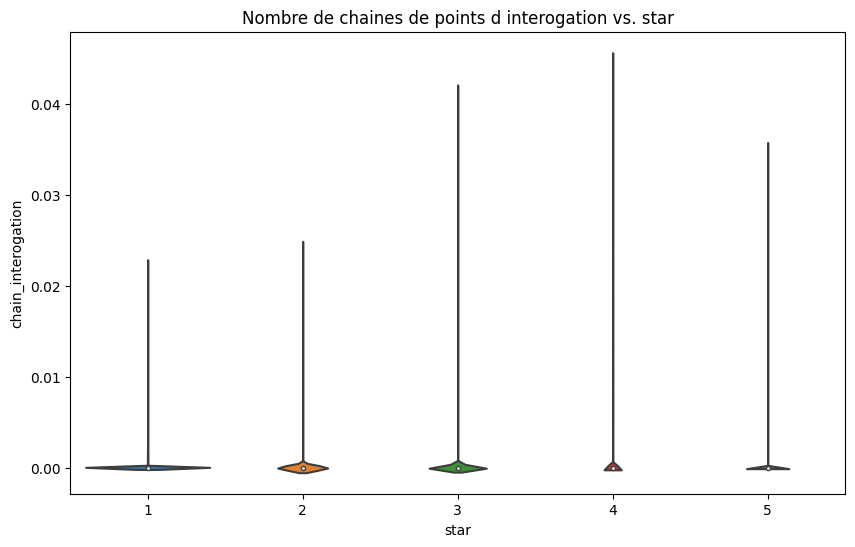

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="star", y="chain_interogation", data=df, ax=ax)
plt.title("Nombre de chaines de points d interogation vs. star")
plt.show()

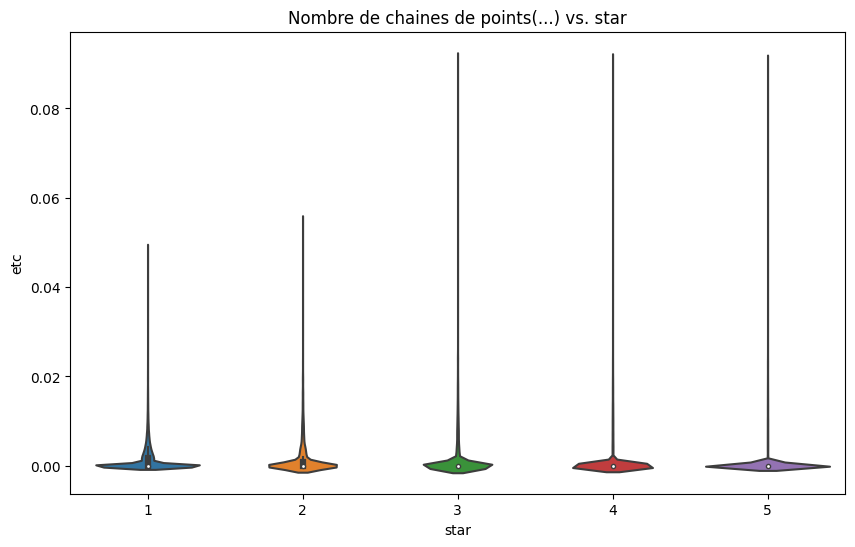

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(x="star", y="etc", data=df, ax=ax)
plt.title("Nombre de chaines de points(...) vs. star")
plt.show()

In [3]:
preprocess_comments(df, n_jobs=8)

105568it [01:09, 1520.71it/s]


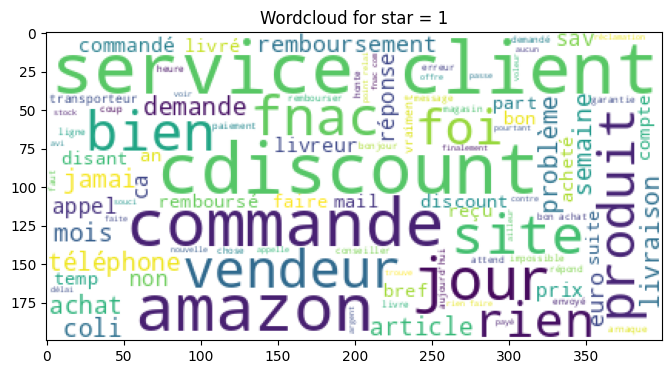

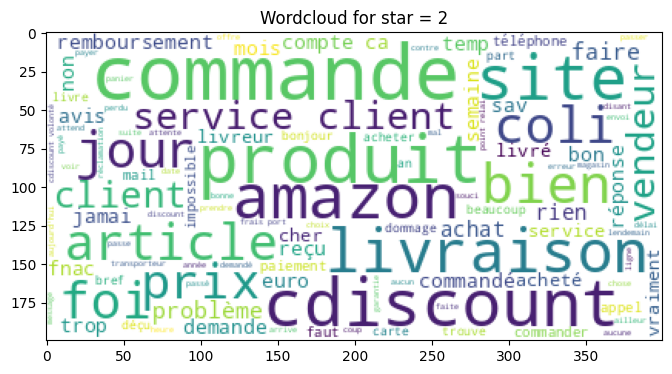

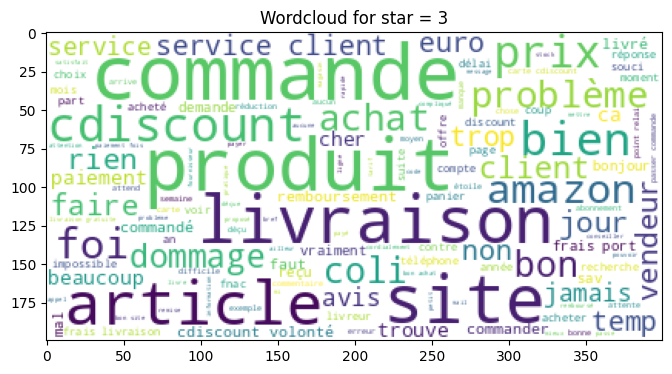

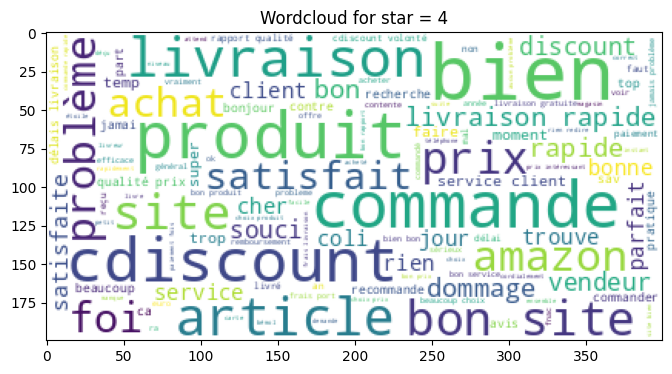

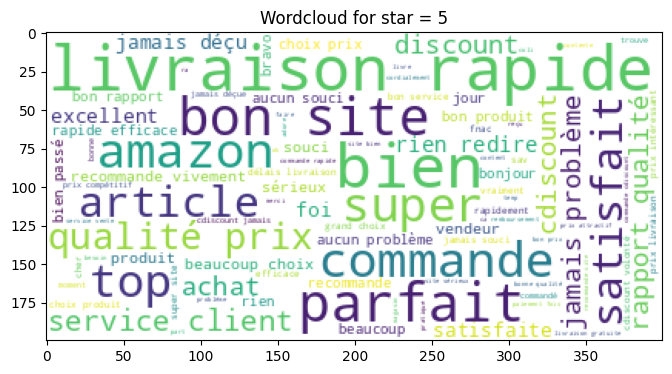

In [6]:
for star in range(1,6):
    title = "Wordcloud for star = "+str(star)
    mask = (df["star"]==star)
    text = "\n".join(df.loc[mask, "cleaned_words"].tolist())
    plot_word_cloud(text, title, stop_words, color="white", max_words=200, figsize=(8,4))

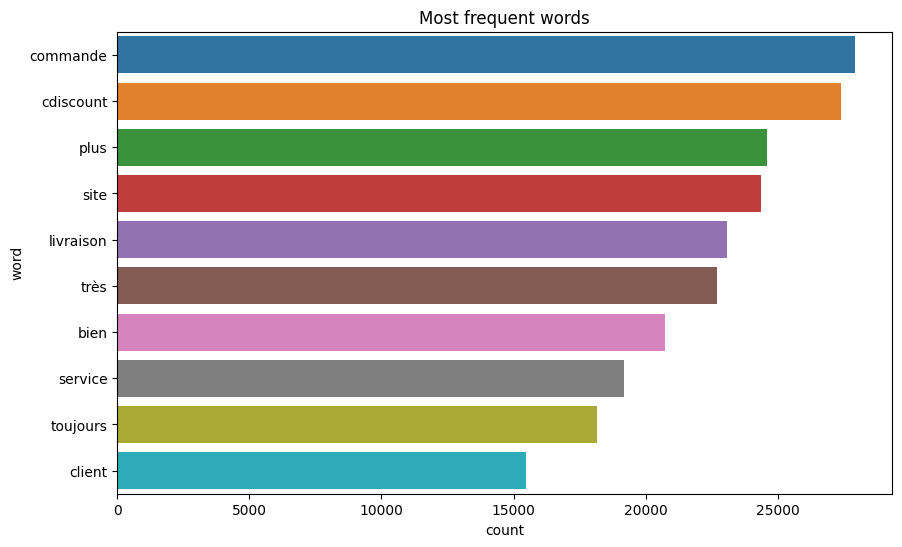

In [15]:
count_words = return_ngram(df.Commentaire, stop_words, ngram_range=(1,1))
plt.figure(figsize=(10,6))
sns.barplot(data=count_words.iloc[:10], x='count', y='word')
plt.title("Most frequent words")
plt.show()

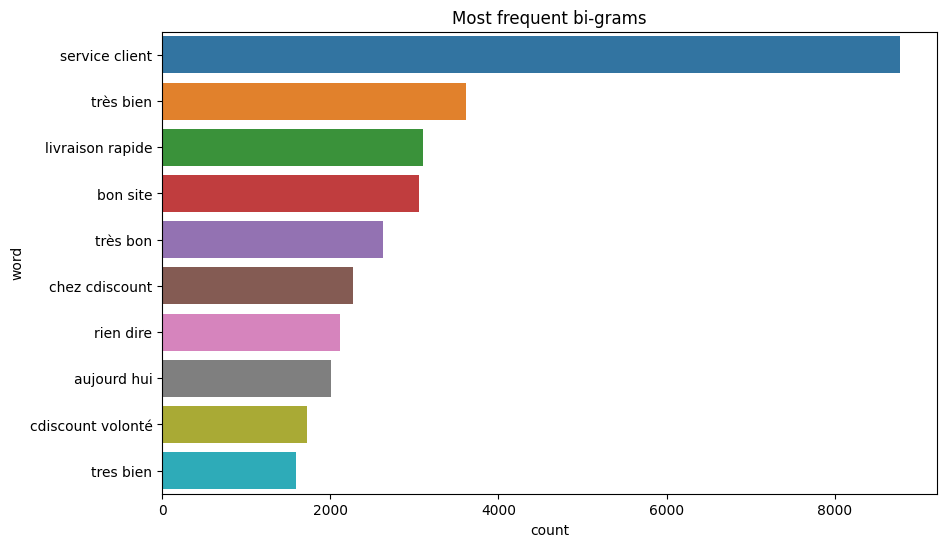

In [16]:
count_words = return_ngram(df.Commentaire, stop_words, ngram_range=(2,2))
plt.figure(figsize=(10,6))
sns.barplot(data=count_words.iloc[:10], x='count', y='word')
plt.title("Most frequent bi-grams")
plt.show()

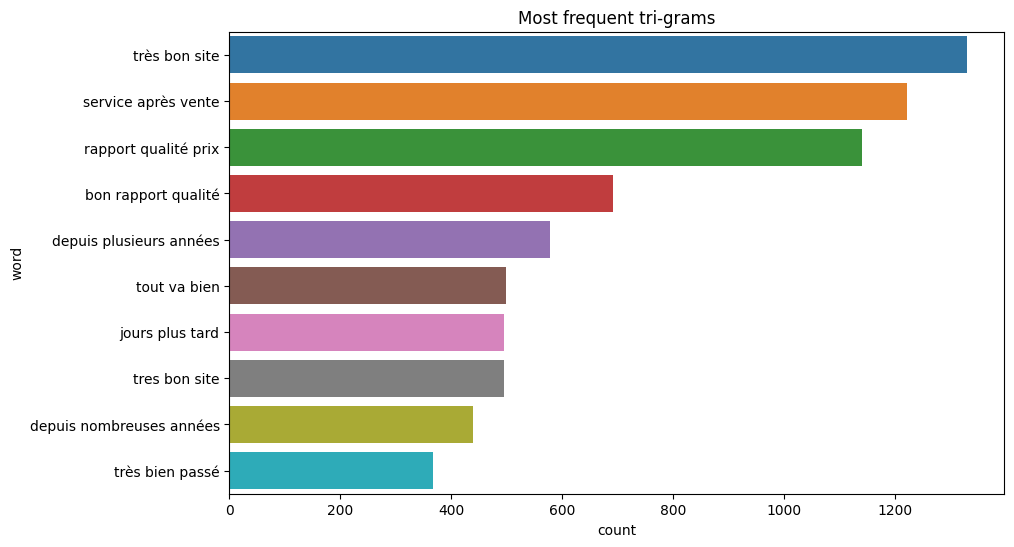

In [13]:
count_words = return_ngram(df.Commentaire, stop_words, ngram_range=(3,3))
plt.figure(figsize=(10,6))
sns.barplot(data=count_words.iloc[:10], x='count', y='word')
plt.title("Most frequent tri-grams")
plt.show()

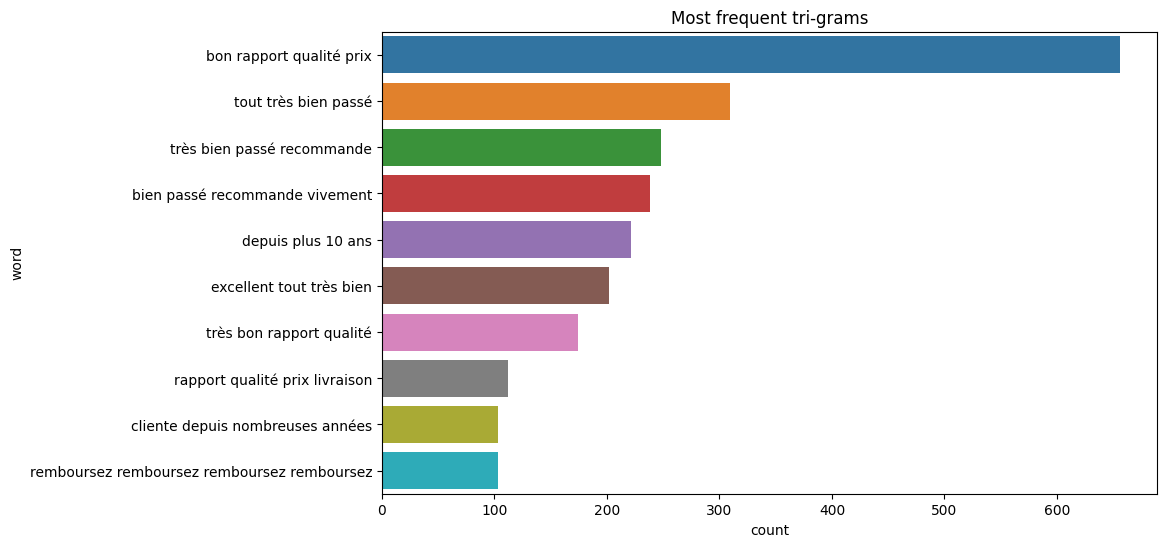

In [14]:
count_words = return_ngram(df.Commentaire, stop_words, ngram_range=(4,4))
plt.figure(figsize=(10,6))
sns.barplot(data=count_words.iloc[:10], x='count', y='word')
plt.title("Most frequent tri-grams")
plt.show()

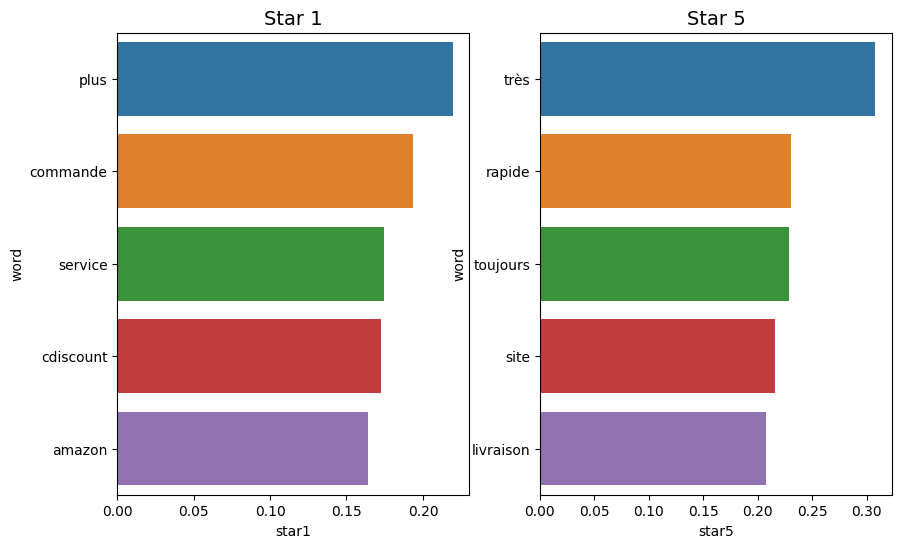

In [15]:
plotNgramsPerStars(df, stop_words, ngram=1, figsize=(10,6))

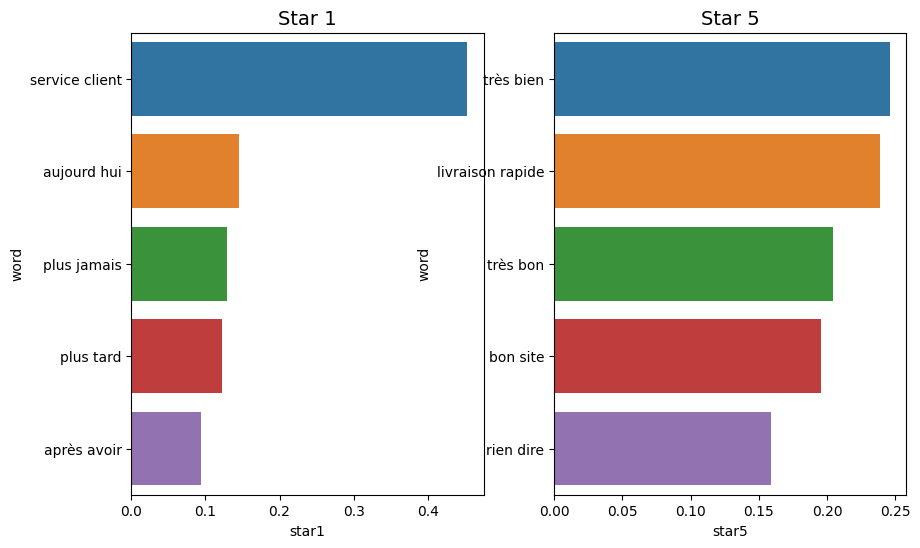

In [16]:
plotNgramsPerStars(df, stop_words, ngram=2, figsize=(10,6))

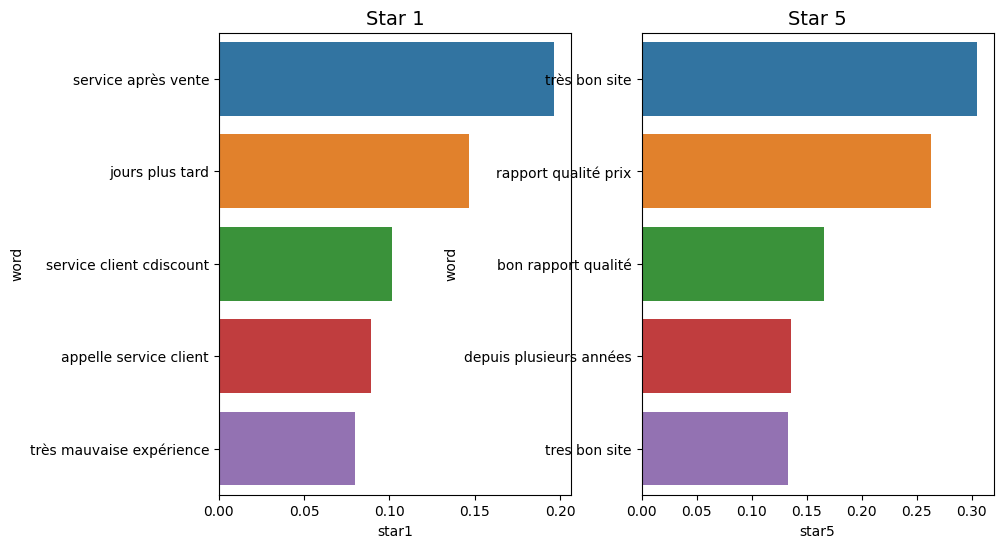

In [17]:
plotNgramsPerStars(df, stop_words, ngram=3, figsize=(10,6))

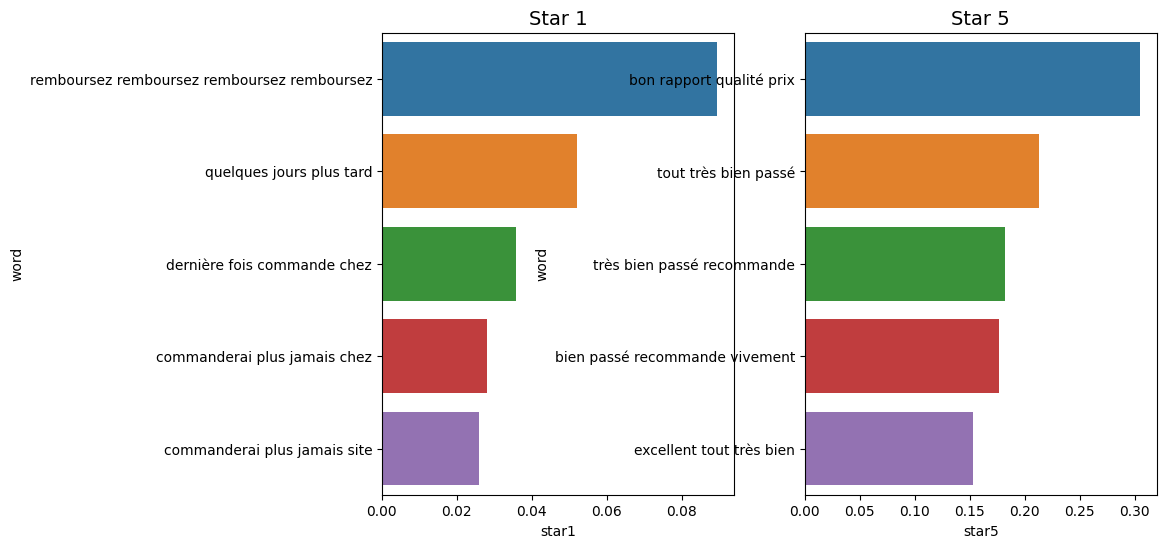

In [18]:
plotNgramsPerStars(df, stop_words, ngram=4, figsize=(10,6))

Le vocabulaire associé aux commentaires positives est lié aux thématiques:  
- User experience sur site web  
- livraison  
- rapport qualité/prix  

  -> Phase de commande > reception du produit

Pour les commentaires négatives:  
- SAV / service client  

  -> Phase post livraison